<a href="https://colab.research.google.com/github/kathmandu777/Research_of_poker_guy/blob/main/img_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 画像分類スクリプト

天下のTensorFlowさん作成のコードを適宜改良した感じです。["chip_kick","move_to_pass","pass"]の三種類のクラスに画像が分類されます。<br>



*   参考:[TensorFlow rock_paper_scissors](https://www.tensorflow.org/datasets/catalog/rock_paper_scissors)
*   参考:[TensorFlow YouTube](https://www.youtube.com/watch?v=k15RnGEOz8o)




In [ ]:
#######################################
#####  学習する画像を読み込む    #######
#######################################

import os

#学習データのフォルダ位置
root_dir='/content/drive/MyDrive/ColabNotebooks/Kida-Research' #colabのGoogleDriveの位置
chip_kick_dir = os.path.join(root_dir,'train_data/chip_kick')
move_to_pass_dir = os.path.join(root_dir,'train_data/move_to_pass')
pass_dir = os.path.join(root_dir,'train_data/pass')

#画像枚数の表示
print('total training chip_kick images:', len(os.listdir(chip_kick_dir)))
print('total training move_to_pass images:', len(os.listdir(move_to_pass_dir)))
print('total training pass_dir images:', len(os.listdir(pass_dir)))


chip_kick_files = os.listdir(chip_kick_dir)  # 引数のディレクトリ位置にあるファイルをリスト形式で返す
print(chip_kick_files[:10])  # 先頭10枚のファイル名を表示

move_to_pass_files = os.listdir(move_to_pass_dir)
print(move_to_pass_files[:10])

pass_files = os.listdir(pass_dir)
print(pass_files[:10])



total training chip_kick images: 1000
total training move_to_pass images: 1000
total training pass_dir images: 1000
['chip_kick_0019.png', 'chip_kick_0634.png', 'chip_kick_0635.png', 'chip_kick_0636.png', 'chip_kick_0637.png', 'chip_kick_0638.png', 'chip_kick_0639.png', 'chip_kick_0640.png', 'chip_kick_0641.png', 'chip_kick_0064.png']
['move_0640.png', 'move_0641.png', 'move_0642.png', 'move_0643.png', 'move_0644.png', 'move_0645.png', 'move_0646.png', 'move_0647.png', 'move_0648.png', 'move_0649.png']
['pass_0640.png', 'pass_0641.png', 'pass_0642.png', 'pass_0643.png', 'pass_0644.png', 'pass_0645.png', 'pass_0646.png', 'pass_0647.png', 'pass_0648.png', 'pass_0649.png']


/content/drive/MyDrive/ColabNotebooks/Kida-Research/train_data/chip_kick/chip_kick_0019.png


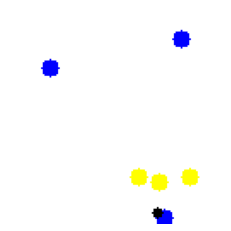

/content/drive/MyDrive/ColabNotebooks/Kida-Research/train_data/chip_kick/chip_kick_0634.png


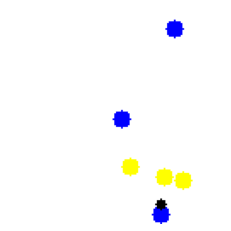

/content/drive/MyDrive/ColabNotebooks/Kida-Research/train_data/move_to_pass/move_0640.png


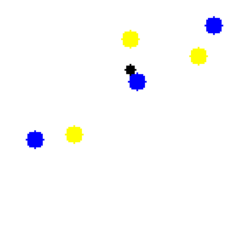

/content/drive/MyDrive/ColabNotebooks/Kida-Research/train_data/move_to_pass/move_0641.png


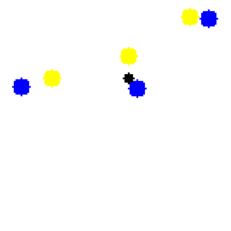

/content/drive/MyDrive/ColabNotebooks/Kida-Research/train_data/pass/pass_0640.png


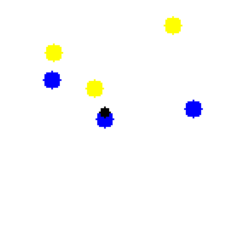

/content/drive/MyDrive/ColabNotebooks/Kida-Research/train_data/pass/pass_0641.png


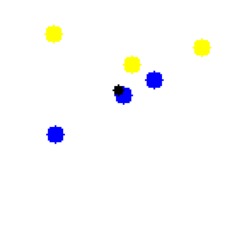

In [ ]:
#######################################
#####  学習する画像を任意枚数表示  #####
#######################################

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


pic_index = 2  # 表示する画像の枚数

next_chip_kick = [os.path.join(chip_kick_dir, fname) 
                for fname in chip_kick_files[pic_index-2:pic_index]]
next_move_to_pass = [os.path.join(move_to_pass_dir, fname) 
                for fname in move_to_pass_files[pic_index-2:pic_index]]
next_pass = [os.path.join(pass_dir, fname) 
                for fname in pass_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_chip_kick+next_move_to_pass+next_pass):
  print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off') # 軸の表示なし
  #plt.title(img_path)
  plt.show()

In [ ]:
#################################################
##   モデルの作成(おそらく。名称に自信がない)  ###
#################################################

import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

import time
import datetime

#ImageDataGeneratorについて：データの前処理（せん断や回転など）を行うのに便利なモジュール
#ドキュメント=https://keras.io/ja/preprocessing/image/

TRAINING_DIR = "/content/drive/MyDrive/ColabNotebooks/Kida-Research/train_data" #学習する画像のあるフォルダ

#学習させる画像の変更度の定義(様々な画像に対応させるため)
#喜田さんの研究は必ず128*128の回転ナシの画像が与えられるためりスケールのみ行うように定義する
training_datagen = ImageDataGenerator(
      rescale = 1./128  #画像サイズを0~1に収めるためにリスケールする
      
      # このコメント文は消去可能。(マンズの勉強用に保存)
	    # rotation_range=0,#回転させない
      # width_shift_range=0,
      # height_shift_range=0,
      # shear_range=0,
      # zoom_range=0,
      # horizontal_flip=False,
      # fill_mode='nearest'#回転させたときに出てくる色のない部分を何色で埋めるかの定義(今回は発生させないため本来は定義不要(おそらく))
)

VALIDATION_DIR = "/content/drive/MyDrive/ColabNotebooks/Kida-Research/test_data" #テスト画像のあるフォルダ
validation_datagen = ImageDataGenerator(rescale = 1./128)



train_generator = training_datagen.flow_from_directory( #training_datagenの定義を用いてflowする
	TRAINING_DIR,#学習する画像のフォルダを指定
	target_size=(128,128),#画像データのサイズ
	class_mode='categorical',# "categorical"か"binary"か"sparse"か"input"か"other"か"None"のいずれか1つ．"categorical"は2次元のone-hotにエンコード化されたラベル
  batch_size=50 # batch_sizeはミニバッチ学習に使われるバッチのサイズ。
)
"""
補足「バッチサイズについて」
  値は任意に調整すれば良いが、テスト用データの枚数を割り切れる数にしないとおかしなことになる可能性があるので注意する。
  参考：https://qiita.com/kenta1984/items/bad75a37d552510e4682
"""

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(128,128),
	class_mode='categorical',
  batch_size=50
)

#モデルの定義
#以下に関連するドキュメント
"""
Conv2Dについて（https://keras.io/ja/layers/convolutional/）

  Conv2D(filters, kernel_size, strides=(1, 1),...)
    filters: 整数で，出力空間の次元（つまり畳み込みにおける出力フィルタの数）
    kernel_size: 2次元の畳み込みウィンドウの幅と高さを指定します. 単一の整数の場合は正方形のカーネル.->カーネル?(フィルター?)のサイズを指定
    activation: 使用する活性化関数の名前(活性化関数一覧：https://keras.io/ja/activations/)
    input_shape: 128*128 RGB画像の時は(128, 128, 3)
"""

"""
MaxPooling2Dについて(https://keras.io/ja/layers/pooling/)

  MaxPooling2D(pool_size=(2, 2), strides=None,...)
    pool_size: ダウンスケールする係数を決める 2つの整数のタプル（垂直，水平）． (2, 2) は画像をそれぞれの次元で半分にします． 1つの整数しか指定ないと，それぞれの次元に対して同じ値が用いられます．
"""

"""
Flattenについて（https://keras.io/ja/layers/core/）
  入力を平坦化する．バッチサイズに影響を与えません．
"""

"""
Dropoutについて（https://keras.io/ja/layers/core/）
  入力にドロップアウトを適用する．過学習の防止に役立つ

  Dropout(rate, noise_shape=None, seed=None)
    rate： 0と1の間の浮動小数点数．入力ユニットをドロップする割合
"""

"""
Denseについて(https://keras.io/ja/layers/core/)
  通常の全結合ニューラルネットワークレイヤー．

  Dense(units, activation=None, use_bias=True,...)
      units：正の整数，出力空間の次元数
      activation： 使用する活性化関数名 （活性化関数一覧：https://keras.io/ja/activations/） 何も指定しなければ，活性化は適用されない（すなわち，"線形"活性化： a(x) = x）
"""

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # ↑ おそらくinput_shape=(150, 150, 3)を適宜変更してという意味
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

#summary()=作成したニューラルネットワークのモデル形状の概要を表示(上で定義したモデルの概要を表示(可視化)?)
model.summary()

"""
compileについて（https://keras.io/ja/models/model/）
  学習のためのモデルを設定

  compile(optimizer, loss=None, metrics=None,...)
    optimizer: 文字列（optimizer名）またはoptimizerのオブジェクト(詳細：https://keras.io/api/optimizers/)
    loss: 文字列（目的関数名）または目的関数（詳細：https://keras.io/api/losses/）
    metrics: 訓練時とテスト時にモデルにより評価される評価関数のリスト．一般的にはmetrics=['accuracy']を使うことになります．

"""
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

"""
fitについて（https://keras.io/ja/models/model/）
  固定回数（データセットの反復）の試行でモデルを学習

  fit(epochs=1, verbose=1,  validation_data=None, validation_steps=None,steps_per_epoch=None,...)
    epochs: 訓練データ配列の反復回数を示す整数．
    verbose: 進行状況の表示モード．0 = 表示なし，1 = プログレスバー，2 = 各試行毎に一行の出力．
    validation_data: 各試行の最後に損失とモデル評価関数を評価するために用いられる(x_val, y_val)のタプル
    steps_per_epoch: 終了した1エポックを宣言して次のエポックを始めるまでのステップ数の合計（サンプルのバッチ）．
    validation_steps: steps_per_epochを指定している場合のみ関係します．停止する前にバリデーションするステップの総数（サンプルのバッチ）．
"""
history = model.fit(train_generator, epochs=25, steps_per_epoch=20, validation_data = validation_generator, verbose = 1, validation_steps=3)


"""
.h5形式のファイルについて(一応)
  Hierarchical Data Formatの略.階層化された形でデータを保存することができるファイル形式

  メリット
    csvよりも読み書きが早い(pickleよりは遅い)
    他の言語でも使える(pickleとは違う点)

"""
model.save(os.path.join(root_dir,"model/model_"+str(datetime.datetime.now().strftime(
        '%Y%m%d-%H%M%S'))+".h5"))


Found 3000 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_______________________________________

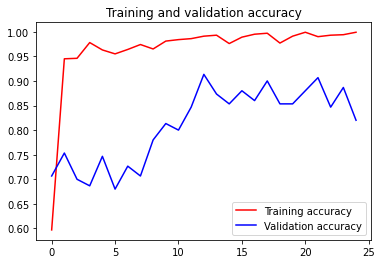

<Figure size 432x288 with 0 Axes>

In [ ]:
##################################################
###  train_dataとtest_dataの適合率のプロット  #####
##################################################

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
#######################################
## 指定の画像でモデルの精度を検査　#####
#######################################

import tensorflow as tf
import keras_preprocessing
import numpy as np
from google.colab import files
from keras.preprocessing import image
import os

try:#modelが定義されているか(90min,12h制限のリセットを受けていないか)
  model
except NameError:
  print("modelが定義されていません。\nモデルファイルの名前を入力してください")
  root_dir='/content/drive/MyDrive/ColabNotebooks/Kida-Research'
  model_list=os.listdir(os.path.join(root_dir,"model"))
  for i,file_name in enumerate(model_list):#modelフォルダにあるファイル名を列挙
    print("  "+str(i)+" : "+str(file_name))
  print("インデックスを入力")
  model=tf.keras.models.load_model(os.path.join(root_dir,"model/"+str(model_list[int(input())])))#modelファイル(.h5形式)を選択

class_name=["chip_kick","move_to_pass","pass"]

isContinue=True

while(isContinue):
  print("\n分類(識別)したい画像を選択してください(複数選択可)")
  uploaded = files.upload()#分類したい画像を選択
    
  for fn in uploaded.keys():
    # predicting images
    path = fn
    img = image.load_img(path, target_size=(128, 128))#128*128サイズで
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    try:
      classes = model.predict(images, batch_size=50)
    except NameError:
      classes = new_model.predict(images, batch_size=50)

    print(fn,end=" = ")
    print(class_name[np.argmax(classes)])
  
  print("\n分類(識別)を続けますか?(Y or n)",end=" ")
  isContinue=True if input()=="Y" else False

# chip_kick画像自動生成
a_haichi.py

(喜田さんが作成したものを適宜編集)

In [ ]:
#以下のスクリプトによって生成される画像の保存先を指定
#test_data <=> train_data　適宜入れ替え
save_dir_chip_kick='/content/drive/MyDrive/ColabNotebooks/Kida-Research/train_data/chip_kick'


In [ ]:
#a_haichi.pyのコピー
#->chip_kick

import cv2
import numpy as np
import random
import os
#!pip install pyautogui
#import pyautogui

circSize = 5

for i in range(0, 1000):
    for j in range(0, 3):
        img = np.full((128, 128, 3), 255, dtype=np.uint8)  # 128×128 全面白
        circColor = (255, 0, 0)  # blue
        x1 = random.randint(5, 122)
        y1 = random.randint(120, 125)
        cv2.circle(img, (x1, y1), circSize, circColor, -1)

        circColor = (255, 0, 0)  # blue
        if x1 < 20:
            x2 = x1 + random.randint(0, 20)

        elif x1 >= 20 and x1 < 105:
            x2 = x1 + random.randint(-15, 20)

        else:
            x2 = x1 + random.randint(-20, 2)

        y2 = random.randint(2, 50)
        cv2.circle(img, (x2, y2), circSize, circColor, -1)

        circColor = (255, 0, 0)  # blue
        if x2 < 20:
            x3 = random.randint(35, 125)

        elif x2 >= 20 and x2 < 105:
            a = x2 - 15
            b = x2 + 15
            while True:
                x3 = random.randint(2, 125)
                if x3 < a or x3 > b:
                    break
        else:
            x3 = random.randint(2, 90)

        y3 = random.randint(2, 90)
        cv2.circle(img, (x3, y3), circSize, circColor, -1)

        circColor = (0, 255, 255)  # yellow
        x4 = x1 + random.randint(-3, 3)
        y4 = y1 - random.randint(18, 25)
        cv2.circle(img, (x4, y4), circSize, circColor, -1)

        circColor = (0, 255, 255)  # yellow
        if x4 < 107:
            x5 = x4 + random.randint(10, 20)

        elif x4 < 112:
            x5 = x4 + random.randint(10, 15)

        else:
            x5 = x4 - random.randint(30, 40)

        y5 = y4 + random.randint(-10, 5)
        cv2.circle(img, (x5, y5), circSize, circColor, -1)

        circColor = (0, 255, 255)  # yellow
        if x4 > 20:
            x6 = x4 - random.randint(10, 20)

        elif x4 > 15:
            x6 = x4 - random.randint(10, 15)

        else:
            x6 = x4 + random.randint(30, 40)

        y6 = y4 + random.randint(-10, 5)
        cv2.circle(img, (x6, y6), circSize, circColor, -1)

        circColor = (0, 0, 0)  # black
        x7 = x1 + random.randint(-5, 5)

        e = y4 + 7  # 　ボールの位置がy4ではだめ
        while True:
            y7 = y1 - random.randint(3, 7)
            if y7 > e:
                break

        cv2.circle(img, (x7, y7), 3, circColor, -1)

        #cv2.namedWindow("display")
        #cv2.imshow("display", img)
        #cv2.moveWindow("display", 100, 200)
        #cv2.waitKey(300)
        #screenshot = pyautogui.screenshot(region=(221, 228, 128, 128))
        #screenshot.save(os.path.join(save_dir_chip_kick,'ck_{0:04d}.png'.format(i)))
        #cv2.destroyWindow("display")
        cv2.imwrite(os.path.join(save_dir_chip_kick,'chip_kick_{0:04d}.png'.format(i)),img)

print("Done:chip_kick")

# move_to_pass画像自動生成
b_haichi?.py

(喜田さんが作成したものを適宜編集)

In [ ]:
#以下のスクリプトによって生成される画像の保存先を指定
#test_data <=> train_data　適宜入れ替え
save_dir_move_to_pass='/content/drive/MyDrive/ColabNotebooks/Kida-Research/train_data/move_to_pass'


In [ ]:
#b_haichi1.py
import cv2
import numpy as np
import random
import os

circSize = 5

for i in range(0,25):
    for j in range(0,3):
        img = np.full((128, 128, 3), 255, dtype = np.uint8) # 128×128 全面白
        circColor = (255, 0, 0)       #blue
        x1 = random.randint(43, 82)   #隣のマスと重ならないように（基準42~83）
        y1 = random.randint(42, 83)
        cv2.circle(img, (x1, y1), circSize, circColor, -1)

        circColor = (0, 255, 255)     #yellow
        x4 = x1 + random.randint(-10, 10)
        y4 = y1 - random.randint(18, 30)
        cv2.circle(img, (x4, y4), circSize, circColor, -1)

        circColor = (0, 255, 255)       #yellow
        x5 = random.randint(9, 40) 
        y5 = random.randint(2, 40)
        cv2.circle(img, (x5, y5), circSize, circColor, -1)

        circColor = (0, 255, 255)       #yellow
        x6 = random.randint(85, 118)
        y6 = random.randint(2, 40)
        cv2.circle(img, (x6, y6), circSize, circColor, -1)

        circColor = (255, 0, 0)     #blue
        a = x5 - 7
        x2 = random.randint(2, a)

        b = y5 + 5

        if y5 >= 2 and y5 < 37:
            y2 = random.randint(2, b)   # y5 + 5まで

        elif y6 >= 37 and y6 < 42:
            y3 = random.randint(2, 41)

        cv2.circle(img, (x2, y2), circSize, circColor, -1)

        circColor = (255, 0, 0)     #blue
        c = x6 + 7
        x3 = random.randint(c, 125)
        
        d = y6 + 5

        if y6 >= 2 and y6 < 37:
            y3 = random.randint(2, d)   # y6 + 5まで

        elif y6 >= 37 and y6 < 42:
            y3 = random.randint(2, 41)

        cv2.circle(img, (x3, y3), circSize, circColor, -1)

        circColor = (0, 0, 0)         #black
        x7 = x1 + random.randint(-5, 5)
        
        e = y4 + 7                    #　ボールの位置がy4ではだめ
        while True:
            y7 = y1 - random.randint(3, 7)
            if y7 > e:
                break

        cv2.circle(img, (x7, y7), 3, circColor, -1)

        cv2.imwrite(os.path.join(save_dir_move_to_pass,'move_{0:04d}.png'.format(i)),img)


In [ ]:
#b_haichi2.py
import cv2
import numpy as np
import random

circSize = 5

for i in range(0,25):
    for j in range(0,3):
        img = np.full((128, 128, 3), 255, dtype = np.uint8) # 128×128 全面白
        circColor = (255, 0, 0)       #blue
        x1 = random.randint(43, 81)   # 右のマスと重ならないように
        y1 = random.randint(42, 83)
        cv2.circle(img, (x1, y1), circSize, circColor, -1)

        circColor = (0, 255, 255)     #yellow
        x4 = x1 + random.randint(-10, 10)
        y4 = y1 - random.randint(18, 30)
        cv2.circle(img, (x4, y4), circSize, circColor, -1)

        circColor = (0, 255, 255)       #yellow
        x5 = random.randint(9, 40) 
        y5 = random.randint(2, 40)
        cv2.circle(img, (x5, y5), circSize, circColor, -1)

        circColor = (0, 255, 255)       #yellow
        x6 = random.randint(86, 118)
        y6 = random.randint(42, 83)
        cv2.circle(img, (x6, y6), circSize, circColor, -1)

        circColor = (255, 0, 0)     #blue
        a = x5 - 7
        x2 = random.randint(2, a)

        b = y5 + 5

        if y5 >= 2 and y5 < 37:
            y2 = random.randint(2, b)   # y6 + 5まで

        elif y5 >= 37 and y5 < 42:
            y2 = random.randint(2, 41)

        cv2.circle(img, (x2, y2), circSize, circColor, -1)

        circColor = (255, 0, 0)     #blue
        c = x6 + 7
        x3 = random.randint(c, 125)
        
        d = y6 + 5
        e = y6 - 5
        f = y6 - 10
        g = y6 + 10
        h = y6 - 15
        k = y6 + 15

        if y6 < 47:
            y3 = random.randint(42, d)  # y6 + 5まで

        elif y6 >= 47 and y6 < 52:
            y3 = random.randint(e, d)   # y6 - 5 から y6 + 5まで

        elif y6 >= 52 and y6 < 57:      # y6 - 10 から y6 + 10まで
            y3 = random.randint(f, g)

        elif y6 >= 57 and y6 < 69:      # y6 - 15 から y6 + 15まで
            y3 = random.randint(h, k)

        elif y6 >= 69 and y6 < 74:
            y3 = random.randint(f, g)   # y6 - 10 から y6 + 10まで

        elif y6 >= 74 and y6 < 79:
            y3 = random.randint(e, d)   # y6 - 5 から y6 + 5まで

        elif y6 >= 79 and y6 < 84:
            y3 = random.randint(e, 83)

        cv2.circle(img, (x3, y3), circSize, circColor, -1)

        circColor = (0, 0, 0)         #black
        x7 = x1 + random.randint(-5, 5)
        
        e = y4 + 7                    #　ボールの位置がy4ではだめ
        while True:
            y7 = y1 - random.randint(3, 7)
            if y7 > e:
                break  

        cv2.circle(img, (x7, y7), 3, circColor, -1)

        cv2.imwrite(os.path.join(save_dir_move_to_pass,'move_{0:04d}.png'.format(i+25)),img)


In [ ]:
#b_haichi3.py

import cv2
import numpy as np
import random

circSize = 5

for i in range(0,25):
    for j in range(0,3):
        img = np.full((128, 128, 3), 255, dtype = np.uint8) # 128×128 全面白
        circColor = (255, 0, 0)       #blue
        x1 = random.randint(44, 81)   #隣のマスと重ならないように（基準42~83）
        y1 = random.randint(42, 83)
        cv2.circle(img, (x1, y1), circSize, circColor, -1)

        circColor = (0, 255, 255)     #yellow
        x4 = x1 + random.randint(-10, 10)
        y4 = y1 - random.randint(17, 30)
        cv2.circle(img, (x4, y4), circSize, circColor, -1)

        circColor = (0, 255, 255)       #yellow
        x5 = random.randint(9, 39) 
        y5 = random.randint(42, 83)
        cv2.circle(img, (x5, y5), circSize, circColor, -1)

        circColor = (0, 255, 255)       #yellow
        x6 = random.randint(86, 118)
        y6 = random.randint(42, 83)
        cv2.circle(img, (x6, y6), circSize, circColor, -1)

        circColor = (255, 0, 0)     #blue
        a = x5 - 7
        x2 = random.randint(2, a)
        
        d1 = y5 + 5
        e1 = y5 - 5
        f1 = y5 - 10
        g1 = y5 + 10
        h1 = y5 - 15
        k1 = y5 + 15

        if y5 < 47:
            y2 = random.randint(42, d1)   # y5 + 5まで

        elif y5 >= 47 and y5 < 52:
            y2 = random.randint(e1, d1)   # y5 - 5 から y5 + 5まで

        elif y5 >= 52 and y5 < 57:        # y5 - 10 から y5 + 10まで
            y2 = random.randint(f1, g1)

        elif y5 >= 57 and y5 < 69:
            y2 = random.randint(h1,k1)    # y6 - 15 から y6 + 15まで

        elif y5 >= 69 and y5 < 74:
            y2 = random.randint(f1, g1)   # y5 - 10 から y5 + 10まで

        elif y5 >= 74 and y5 < 79:
            y2 = random.randint(e1, d1)   # y5 - 5 から y5 + 5まで

        elif y5 >= 79 and y5 < 84:
            y2 = random.randint(e1, 83)

        cv2.circle(img, (x2, y2), circSize, circColor, -1)

        circColor = (255, 0, 0)     #blue
        c = x6 + 7
        x3 = random.randint(c, 125)
        
        d = y6 + 5
        e = y6 - 5
        f = y6 - 10
        g = y6 + 10
        h = y6 - 15
        k = y6 + 15

        if y6 < 47:
            y3 = random.randint(42, d)  # y6 + 5まで

        elif y6 >= 47 and y6 < 52:
            y3 = random.randint(e, d)   # y6 - 5 から y6 + 5まで

        elif y6 >= 52 and y6 < 57:      # y6 - 10 から y6 + 10まで
            y3 = random.randint(f, g)

        elif y6 >= 57 and y6 < 69:      # y6 - 15 から y6 + 15まで
            y3 = random.randint(h, k)

        elif y6 >= 69 and y6 < 74:
            y3 = random.randint(f, g)   # y6 - 10 から y6 + 10まで

        elif y6 >= 74 and y6 < 79:
            y3 = random.randint(e, d)   # y6 - 5 から y6 + 5まで

        elif y6 >= 79 and y6 < 84:
            y3 = random.randint(e, 83)

        cv2.circle(img, (x3, y3), circSize, circColor, -1)

        circColor = (0, 0, 0)         #black
        x7 = x1 + random.randint(-5, 5)
        
        e = y4 + 7                    #　ボールの位置がy4ではだめ
        while True:
            y7 = y1 - random.randint(3, 7)
            if y7 > e:
                break  

        cv2.circle(img, (x7, y7), 3, circColor, -1)

        cv2.imwrite(os.path.join(save_dir_move_to_pass,'move_{0:04d}.png'.format(i+50)),img)


In [ ]:
#b_haichi4.pyのコピー
#->move_to_pass

import cv2
import numpy as np
import random

circSize = 5

for i in range(0,925):
    for j in range(0,3):
        img = np.full((128, 128, 3), 255, dtype = np.uint8) # 128×128 全面白
        circColor = (255, 0, 0)       #blue
        x1 = random.randint(44, 82)
        y1 = random.randint(42, 83)
        cv2.circle(img, (x1, y1), circSize, circColor, -1)

        circColor = (0, 255, 255)     #yellow
        x4 = x1 + random.randint(-10, 10)
        y4 = y1 - random.randint(18, 30)
        cv2.circle(img, (x4, y4), circSize, circColor, -1)

        circColor = (0, 255, 255)       #yellow
        x5 = random.randint(9, 39) 
        y5 = random.randint(42, 83)
        cv2.circle(img, (x5, y5), circSize, circColor, -1)

        circColor = (0, 255, 255)       #yellow
        x6 = random.randint(85, 118)
        y6 = random.randint(2, 40)
        cv2.circle(img, (x6, y6), circSize, circColor, -1)

        circColor = (255, 0, 0)     #blue
        a = x5 - 7
        x2 = random.randint(2, a)
        
        d = y5 + 5
        e = y5 - 5
        f = y5 - 10
        g = y5 + 10
        h = y5 - 15
        k = y5 + 15
        
        if y5 < 47:
            y2 = random.randint(42, d)  # y5 + 5まで

        elif y5 >= 47 and y5 < 52:
            y2 = random.randint(e, d)   # y5 - 5 から y5 + 5まで

        elif y5 >= 52 and y5 < 57:      # y5 - 10 から y5 + 10まで
            y2 = random.randint(f, g)

        elif y5 >= 57 and y5 < 69:      # y5 - 15 から y5 + 15まで
            y2 = random.randint(h, k)

        elif y5 >= 69 and y5 < 74:
            y2 = random.randint(f, g)   # y5 - 10 から y5 + 10まで

        elif y5 >= 74 and y5 < 79:
            y2 = random.randint(e, d)   # y5 - 5 から y5 + 5まで

        elif y5 >= 79 and y5 < 84:
            y2 = random.randint(e, 83)

        
        cv2.circle(img, (x2, y2), circSize, circColor, -1)

        circColor = (255, 0, 0)     #blue
        c = x6 + 7
        x3 = random.randint(c, 125)

        d1 = y6 + 5

        if y6 >= 2 and y6 < 37:
            y3 = random.randint(2, d1)   # y6 + 5まで

        elif y6 >= 37 and y6 < 42:
            y3 = random.randint(2, 41)

        cv2.circle(img, (x3, y3), circSize, circColor, -1)

        circColor = (0, 0, 0)         #black
        x7 = x1 + random.randint(-5, 5)
        
        e = y4 + 7                    #　ボールの位置がy4ではだめ
        while True:
            y7 = y1 - random.randint(3, 7)
            if y7 > e:
                break  

        cv2.circle(img, (x7, y7), 3, circColor, -1)

        cv2.imwrite(os.path.join(save_dir_move_to_pass,'move_{0:04d}.png'.format(i+75)),img)

print("Done:move_to_pass")

# pass画像自動生成
c_haichi?.py

(喜田さんが作成したものを適宜編集)

In [ ]:
#以下のスクリプトによって生成される画像の保存先を指定
#test_data <=> train_data　適宜入れ替え
save_dir_pass='/content/drive/MyDrive/ColabNotebooks/Kida-Research/train_data/pass'


In [ ]:
#c_haichi1.py

import cv2
import numpy as np
import random
import os

circSize = 5

for i in range(0,20):
    for j in range(0,3):
        img = np.full((128, 128, 3), 255, dtype = np.uint8) # 128×128 全面白
        circColor = (255, 0, 0)       #blue
        x1 = random.randint(44, 81)   #隣のマスと重ならないように（基準42~83）
        y1 = random.randint(42, 83)
        cv2.circle(img, (x1, y1), circSize, circColor, -1)

        circColor = (0, 255, 255)     #yellow
        while True:
            x4 = x1 + random.randint(-10, 10)
            if x4 < 80:
                break

        y4 = y1 - random.randint(15, 25)
        cv2.circle(img, (x4, y4), circSize, circColor, -1)

        circColor = (0, 255, 255)       #yellow
        x5 = random.randint(9, 39) 
        y5 = random.randint(42, 83)
        cv2.circle(img, (x5, y5), circSize, circColor, -1)

        circColor = (0, 255, 255)       #yellow
        x6 = random.randint(86, 118)
        y6 = random.randint(42, 83)
        cv2.circle(img, (x6, y6), circSize, circColor, -1)

        circColor = (255, 0, 0)     #blue
        a = x5 - 7
        x2 = random.randint(2, a)
        
        d1 = y5 + 5
        e1 = y5 - 5
        f1 = y5 - 10
        g1 = y5 + 10
        h1 = y5 - 15
        k1 = y5 + 15

        if y5 < 47:
            y2 = random.randint(42, d1)   # y5 + 5まで

        elif y5 >= 47 and y5 < 52:
            y2 = random.randint(e1, d1)   # y5 - 5 から y5 + 5まで

        elif y5 >= 52 and y5 < 57:        # y5 - 10 から y5 + 10まで
            y2 = random.randint(f1, g1)

        elif y5 >= 57 and y5 < 69:
            y2 = random.randint(h1,k1)    # y6 - 15 から y6 + 15まで

        elif y5 >= 69 and y5 < 74:
            y2 = random.randint(f1, g1)   # y5 - 10 から y5 + 10まで

        elif y5 >= 74 and y5 < 79:
            y2 = random.randint(e1, d1)   # y5 - 5 から y5 + 5まで

        elif y5 >= 79 and y5 < 84:
            y2 = random.randint(e1, 83)

        cv2.circle(img, (x2, y2), circSize, circColor, -1)

        circColor = (255, 0, 0)     #blue
        x3 = random.randint(85, 125)
        
        y3 = random.randint(2, 37)  #下のマスとかぶらないように
        cv2.circle(img, (x3, y3), circSize, circColor, -1)

        circColor = (0, 0, 0)        #black
        x7 = x1 + random.randint(-5, 5)
        
        e = y4 + 7                    #　ボールの位置がy4ではだめ
        while True:
            y7 = y1 - random.randint(3, 7)
            if y7 > e:
                break  

        cv2.circle(img, (x7, y7), 3, circColor, -1)

        cv2.imwrite(os.path.join(save_dir_pass,'pass_{0:04d}.png'.format(i)),img)


In [ ]:
#c_haichi2.py

import cv2
import numpy as np
import random

circSize = 5

for i in range(0,20):
    for j in range(0,3):
        img = np.full((128, 128, 3), 255, dtype = np.uint8) # 128×128 全面白
        circColor = (255, 0, 0)       #blue
        x1 = random.randint(44, 81)   #隣のマスと重ならないように（基準42~83）
        y1 = random.randint(42, 83)
        cv2.circle(img, (x1, y1), circSize, circColor, -1)

        circColor = (0, 255, 255)     #yellow
        x4 = x1 + random.randint(-10, 10)
        y4 = y1 - random.randint(17, 30)
        cv2.circle(img, (x4, y4), circSize, circColor, -1)

        circColor = (0, 255, 255)       #yellow
        x5 = random.randint(9, 39) 
        y5 = random.randint(42, 83)
        cv2.circle(img, (x5, y5), circSize, circColor, -1)

        circColor = (0, 255, 255)       #yellow
        x6 = random.randint(86, 118)
        y6 = random.randint(42, 83)
        cv2.circle(img, (x6, y6), circSize, circColor, -1)

        circColor = (255, 0, 0)     #blue
        x2 = random.randint(2, 39)
        
        y2 = random.randint(2, 37)

        cv2.circle(img, (x2, y2), circSize, circColor, -1)

        circColor = (255, 0, 0)     #blue
        c = x6 + 7
        x3 = random.randint(c, 125)
        
        d = y6 + 5
        e = y6 - 5
        f = y6 - 10
        g = y6 + 10
        h = y6 - 15
        k = y6 + 15

        if y6 < 47:
            y3 = random.randint(42, d)  # y6 + 5まで

        elif y6 >= 47 and y6 < 52:
            y3 = random.randint(e, d)   # y6 - 5 から y6 + 5まで

        elif y6 >= 52 and y6 < 57:      # y6 - 10 から y6 + 10まで
            y3 = random.randint(f, g)

        elif y6 >= 57 and y6 < 69:      # y6 - 15 から y6 + 15まで
            y3 = random.randint(h, k)

        elif y6 >= 69 and y6 < 74:
            y3 = random.randint(f, g)   # y6 - 10 から y6 + 10まで

        elif y6 >= 74 and y6 < 79:
            y3 = random.randint(e, d)   # y6 - 5 から y6 + 5まで

        elif y6 >= 79 and y6 < 84:
            y3 = random.randint(e, 83)

        cv2.circle(img, (x3, y3), circSize, circColor, -1)

        circColor = (0, 0, 0)         #black
        x7 = x1 + random.randint(-5, 5)
        
        e = y4 + 7                    #　ボールの位置がy4ではだめ
        while True:
            y7 = y1 - random.randint(3, 7)
            if y7 > e:
                break  

        cv2.circle(img, (x7, y7), 3, circColor, -1)

        cv2.imwrite(os.path.join(save_dir_pass,'pass_{0:04d}.png'.format(i+20)),img)


In [ ]:
#c_haichi3.py

import cv2
import numpy as np
import random

circSize = 5

for i in range(0,20):
    for j in range(0,3):
        img = np.full((128, 128, 3), 255, dtype = np.uint8) # 128×128 全面白
        circColor = (255, 0, 0)       #blue
        x1 = random.randint(43, 82)   #隣のマスと重ならないように（基準42~83）
        y1 = random.randint(42, 83)
        cv2.circle(img, (x1, y1), circSize, circColor, -1)

        circColor = (0, 255, 255)     #yellow
        while True:
            x4 = x1 + random.randint(-10, 10)
            if x4 < 80:
                break

        y4 = y1 - random.randint(18, 30)
        cv2.circle(img, (x4, y4), circSize, circColor, -1)

        circColor = (0, 255, 255)       #yellow
        x5 = random.randint(9, 40) 
        y5 = random.randint(2, 40)
        cv2.circle(img, (x5, y5), circSize, circColor, -1)

        circColor = (0, 255, 255)       #yellow
        x6 = random.randint(85, 125)
        y6 = random.randint(2, 40)
        cv2.circle(img, (x6, y6), circSize, circColor, -1)

        circColor = (255, 0, 0)     #blue
        a = x5 - 7
        x2 = random.randint(2, a)

        b = y5 + 5

        if y5 >= 2 and y5 < 37:
            y2 = random.randint(2, b)   # y5 + 5まで

        elif y6 >= 37 and y6 < 42:
            y2 = random.randint(2, 41)

        cv2.circle(img, (x2, y2), circSize, circColor, -1)

        circColor = (255, 0, 0)     #blue
        while True:
            x3 = random.randint(85, 125)
            c = x1 + 15
            if x3 > c:              #x1のロボと15以上離す
                break
        
        y3 = random.randint(43, 83)

        cv2.circle(img, (x3, y3), circSize, circColor, -1)

        circColor = (0, 0, 0)         #black
        x7 = x1 + random.randint(-5, 5)
        
        e = y4 + 7                    #　ボールの位置がy4ではだめ
        while True:
            y7 = y1 - random.randint(3, 7)
            if y7 > e:
                break

        cv2.circle(img, (x7, y7), 3, circColor, -1)

        cv2.imwrite(os.path.join(save_dir_pass,'pass_{0:04d}.png'.format(i+40)),img)


In [ ]:
#c_haichi4.py

import cv2
import numpy as np
import random

circSize = 5

for i in range(0,20):
    for j in range(0,3):
        img = np.full((128, 128, 3), 255, dtype = np.uint8) # 128×128 全面白
        circColor = (255, 0, 0)       #blue
        x1 = random.randint(44, 82)   #隣のマスと重ならないように（基準42~83）
        y1 = random.randint(42, 83)
        cv2.circle(img, (x1, y1), circSize, circColor, -1)

        circColor = (0, 255, 255)     #yellow
        while True:
            x4 = x1 + random.randint(-10, 10)
            if x4 > 43:
                break

        y4 = y1 - random.randint(18, 30)
        cv2.circle(img, (x4, y4), circSize, circColor, -1)

        circColor = (0, 255, 255)       #yellow
        x5 = random.randint(2, 40) 
        y5 = random.randint(2, 38)
        cv2.circle(img, (x5, y5), circSize, circColor, -1)

        circColor = (0, 255, 255)       #yellow
        x6 = random.randint(85, 118)
        y6 = random.randint(2, 40)
        cv2.circle(img, (x6, y6), circSize, circColor, -1)

        circColor = (255, 0, 0)     #blue
        while True:
            x2 = random.randint(2, 41)
            a = x1 - 15
            if x2 < a:
                break

        y2 = random.randint(43, 83)

        cv2.circle(img, (x2, y2), circSize, circColor, -1)

        circColor = (255, 0, 0)     #blue
        c = x6 + 7
        x3 = random.randint(c, 125)
        
        d = y6 + 5

        if y6 >= 2 and y6 < 37:
            y3 = random.randint(2, d)   # y6 + 5まで

        elif y6 >= 37 and y6 < 42:
            y3 = random.randint(2, 41)

        cv2.circle(img, (x3, y3), circSize, circColor, -1)

        circColor = (0, 0, 0)         #black
        x7 = x1 + random.randint(-5, 5)
        
        e = y4 + 7                    #　ボールの位置がy4ではだめ
        while True:
            y7 = y1 - random.randint(3, 7)
            if y7 > e:
                break

        cv2.circle(img, (x7, y7), 3, circColor, -1)

        cv2.imwrite(os.path.join(save_dir_pass,'pass_{0:04d}.png'.format(i+60)),img)


In [ ]:
#c_haichi5.py
#->pass
import cv2
import numpy as np
import random

circSize = 5

for i in range(0,920):
    for j in range(0,3):
        img = np.full((128, 128, 3), 255, dtype = np.uint8) # 128×128 全面白
        circColor = (255, 0, 0)       #blue
        x1 = random.randint(44, 82)   #隣のマスと重ならないように（基準42~83）
        y1 = random.randint(42, 83)
        cv2.circle(img, (x1, y1), circSize, circColor, -1)

        circColor = (0, 255, 255)     #yellow
        while True:
            x4 = x1 + random.randint(-10, 10)
            if x4 > 43:
                break

        y4 = y1 - random.randint(18, 30)
        cv2.circle(img, (x4, y4), circSize, circColor, -1)

        circColor = (0, 255, 255)       #yellow
        x5 = random.randint(2, 40) 
        y5 = random.randint(2, 38)
        cv2.circle(img, (x5, y5), circSize, circColor, -1)

        circColor = (0, 255, 255)       #yellow
        x6 = random.randint(85, 125)
        y6 = random.randint(2, 38)
        cv2.circle(img, (x6, y6), circSize, circColor, -1)

        circColor = (255, 0, 0)     #blue
        while True:
            x2 = random.randint(2, 41)
            a = x1 - 15
            if x2 < a:
                break

        y2 = random.randint(43, 83)

        cv2.circle(img, (x2, y2), circSize, circColor, -1)

        circColor = (255, 0, 0)     #blue
        while True:
            x3 = random.randint(85, 125)
            b = x1 + 15
            if x3 > b:              #x1のロボと15以上離す
                break

        y3 = random.randint(43, 83)

        cv2.circle(img, (x3, y3), circSize, circColor, -1)

        circColor = (0, 0, 0)         #black
        x7 = x1 + random.randint(-5, 5)
        
        e = y4 + 7                    #　ボールの位置がy4ではだめ
        while True:
            y7 = y1 - random.randint(3, 7)
            if y7 > e:
                break

        cv2.circle(img, (x7, y7), 3, circColor, -1)

        cv2.imwrite(os.path.join(save_dir_pass,'pass_{0:04d}.png'.format(i+80)),img)

print("Done:pass")